In [1]:
%matplotlib widget  
%config InlineBackend.figure_format = 'retina'

In [2]:
!pip install acor 

import acor
import celerite
import corner
import emcee
import h5py
import scipy.optimize as so
import scipy.signal as ss
import seaborn as sns


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [3]:
sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

Execute the cell below to download the binary hour (4096 seconds) of data from H1 surrounding GW150914.  According to [the MD5 checksums](https://losc.ligo.org/s/events/GW150914/md5.txt), it should have a MD5 hash of `ee736548a487222643db5773cf4de954`.

In [7]:
import pandas as pd 
import matplotlib.pyplot as plt

data = pd.read_csv('/Users/neisner/Documents/code/WtLSP/data/sim_tess_sampling.txt', names = ['time', 'flux'], delimiter = ' ')

ts = data['time'].values
fls = data['flux'].values

In [5]:
# with h5py.File('H-H1_LOSC_4_V2-1126257414-4096.hdf5', 'r') as inp:
#     h1_strain = array(inp['strain']['Strain'])
#     t0 = inp['meta']['GPSstart'][()]
#     dt = 1.0/4096.0 # It is INSANE that this is not stored in the HDF5 fil
#     ts = arange(t0, t0 + dt*(h1_strain.shape[0]-0.5), dt)
# tGW150914 = 1126259462 # From LOSC, presumably rounded to nearest second

A quick plot, just to check that we're looking at strain data:

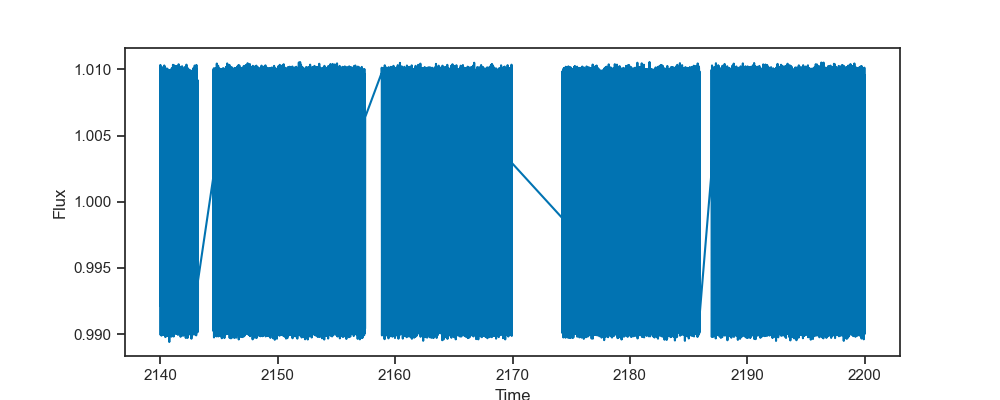

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

plt.plot(ts, fls)
plt.xlabel('Time')
plt.ylabel(r'Flux')
plt.show()

Let's look a bit closer

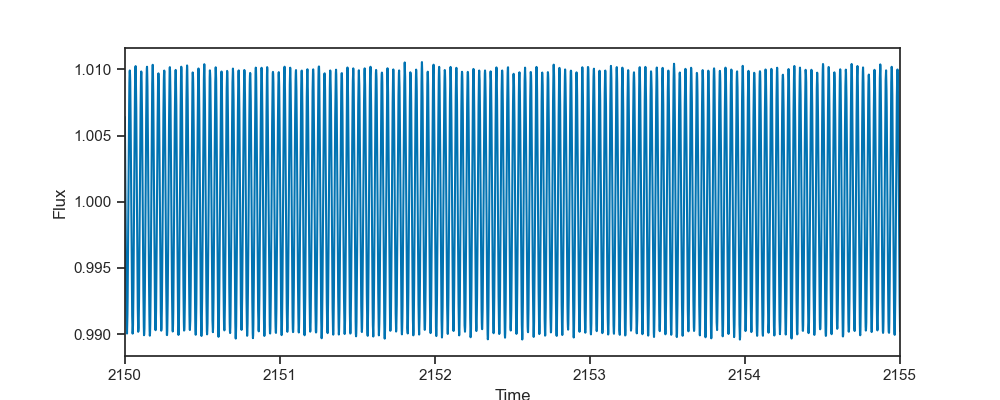

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

plt.plot(ts, fls)
plt.xlabel('Time')
plt.ylabel(r'Flux')
plt.xlim(2150,2155)
plt.show()

As expected, it looks pretty ugly, with lots of low-frequency noise, etc.  How about if we estimate a power spectrum for an eight-second stretch of data from the full binary hour; what does that look like?  In this notebook, we are going to try to regress out the 60 Hz line (I know that it's not exactly coherent, but so much the better!), so I have drawn a vertical line at 60 Hz.

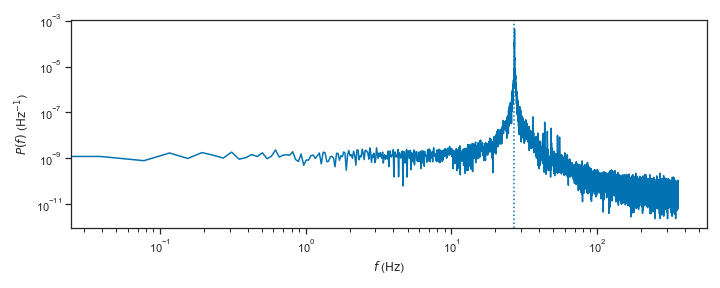

In [114]:
fig, ax = plt.subplots(figsize=(10, 4))

inv_cadence = 86400/120.

# fs is the sampling frequency (in Hz) and nperseg is the number of samples per segment
fs8, psd8 = ss.welch(fls, fs=86400/120., nperseg=37201/2)
plt.loglog(fs8, psd8)
plt.xlabel(r'$f$ ($\mathrm{Hz}$)')
plt.ylabel(r'$P(f)$ ($\mathrm{Hz}^{-1}$)')
plt.axvline(170/(np.pi*2), color=sns.color_palette()[0], ls=':')
#plt.axis(xmin=10)
plt.tight_layout()
plt.show()

Let's zoom in on the 60 Hz line:

27.05634032562221


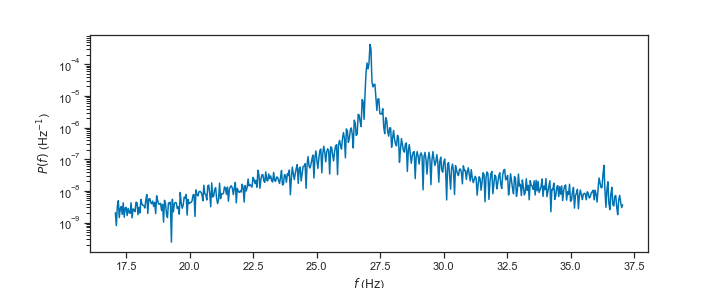

In [115]:
main_mode = 170/(np.pi*2)

print (main_mode)
sel = abs(fs8 - main_mode) < 10

fig, ax = plt.subplots(figsize=(10, 4))

plt.plot(fs8[sel], psd8[sel])
plt.yscale('log')
plt.xlabel(r'$f$ ($\mathrm{Hz}$)')
plt.ylabel(r'$P(f)$ ($\mathrm{Hz}^{-1}$)')
plt.show()

Let's extract a narrow frequency window around 27 Hz using a Butterworth filter at 4th order.  This will preserve the line amplitude and phase, but remove most of the other junk in the data, which would otherwise confuse the fit.  For reasons I don't understand (narrow bandwith makes the filter too long?), any order higher than 4 fails with a cryptic error message, but this should be good enough:

In [116]:
fny = inv_cadence/2.0
flow = 27 - 5
fhigh = 57 + 5
bb, aa = ss.butter(4, array([flow, fhigh])/fny, btype='bandpass')
filtered_fls = ss.filtfilt(bb, aa, fls)

inv_cadence

720.0

Let's just check that the signal now looks reasonable: variations of much smaller amplitude (since we've filtered out all the seismic junk at low frequencies), and pretty monochromatic:

[]

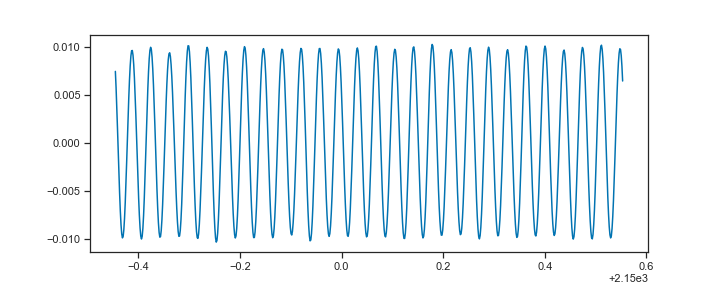

In [117]:
fig, ax = plt.subplots(figsize=(10, 4))

plt.plot(ts[8*int(inv_cadence):9*int(inv_cadence)], filtered_fls[8*int(inv_cadence):9*int(inv_cadence)])

plt.plot()

Just to confirm that we haven't messed with the line amplitude, here's a PSD estimated (on the same eight-second window) from the data before and after filtering:

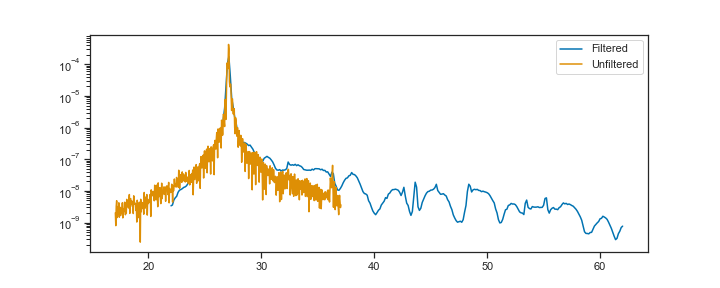

In [123]:
fig, ax = plt.subplots(figsize=(10, 4))

filtered_fs8, filtered_psd8 = ss.welch(filtered_fls, fs=inv_cadence, nperseg=8*inv_cadence)
filteres_sel = (filtered_fs8 >= flow) & (filtered_fs8 <= fhigh)

plt.plot(filtered_fs8[filteres_sel], filtered_psd8[filteres_sel], label='Filtered')
plt.plot(fs8[sel], psd8[sel], label='Unfiltered')
plt.yscale('log')
plt.legend(loc='best')

The sampler will need to have an "error" term, or else it will try to regress out *all* the data using the 60 Hz line.  We will give it the estimate of the variance in the filtered data *outside* the line; then it will try to regress out the 60 Hz line until what is left has that variance.

In [120]:
df = fs8[1]-fs8[0]
variance = sum(df*filtered_psd8[filtered_psd8 < 1e-45])
sigma_guess = sqrt(variance)
sigma_guess

0.0

Because we have severely limited the bandwidth of the signals in the data, we can now agressively down-sample and retain all the information (we don't have to worry about aliasing since we are looking for a 60 Hz line---and we know that it's 60 Hz to pretty good accuracy).  We can downsample until the Nyquist frequency is equal to the bandwidth of the filter, or to sample rates of:

In [121]:
srate_downsample = (fhigh-flow)*2
downsample_factor = int(round(4096/srate_downsample))
print('srate downsampled = {:.0f} Hz, or a factor of {:d}'.format(srate_downsample, downsample_factor))

srate downsampled = 80 Hz, or a factor of 51


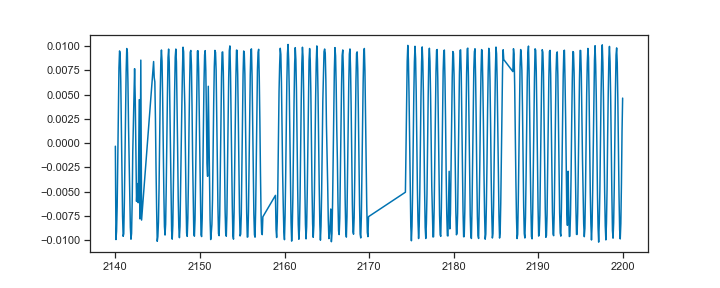

In [124]:
fig, ax = plt.subplots(figsize=(10, 4))

downsampled_ts = ts[::downsample_factor]
downsampled_strain = filtered_fls[::downsample_factor]
plot(downsampled_ts, downsampled_strain)

Now we will build a Celerite model.  It has a stochastically-driven SHO which we initially set to 60 Hz with high Q (don't worry, these initial parameters won't ever get used), plus a "jitter" term that we use to model the white noise in the downsampled data.

In [125]:
kernel = celerite.terms.SHOTerm(log(1.0), log(1000.0), log(2*pi*60.0)) + celerite.terms.JitterTerm(log(sigma_guess))
gp = celerite.GP(kernel, mean=mean(downsampled_strain), fit_mean=True)

/var/folders/cq/dyd07h4n7wl_x1s67x4snjx40000gq/T/ipykernel_53774/2158675994.py:1: RuntimeWarning: divide by zero encountered in log
  kernel = celerite.terms.SHOTerm(log(1.0), log(1000.0), log(2*pi*60.0)) + celerite.terms.JitterTerm(log(sigma_guess))


The parameter names, in case you need to refer to them:

In [126]:
gp.get_parameter_names()

('kernel:terms[0]:log_S0',
 'kernel:terms[0]:log_Q',
 'kernel:terms[0]:log_omega0',
 'kernel:terms[1]:log_sigma',
 'mean:value')

###### Start of Data Tempering Section

I started by fitting about 32 seconds of data because that was pretty efficient in getting a converged posterior quickly; but with such short data segments the quality factor is limited by $Q_\mathrm{max} \sim 1/(fT)$ so is not really measured.  You will see below that $Q$ is large enough that we need $\sim 130\,\mathrm{s}$ of data before the prior is no longer influencing the fit in $Q$.

Eventually, we will want to fit the whole data set, but it is inefficient to try to fit "out of the gate."  My procedure here is to start with the 32 second data set, get a converged posterior, and then double the amount of data (to 64 seconds), get a converged posterior, double, ....  Eventually you fit the whole data set (which takes about three seconds per likelihood evaluation), at which point you stop when you have $\mathcal{O}(1000)$ indpendent samples.  The technical name for this process is "data tempering."

In [127]:
Tstart_sec = 0
Tend_sec = Tstart_sec + 4096

Tstart = int(round(Tstart_sec*srate_downsample))
Tend = Tstart + int(round((Tend_sec - Tstart_sec)*srate_downsample))

Mostly `logpost` just uses `celerite` to compute the data $\log \mathcal{L}$, but I found it helpful to put a couple of priors to control the fit initially during burnin.  

I put a log normal prior on the frequency:
$$
\log f \sim N\left( \log 60 \, \mathrm{Hz}, 0.01 \right)
$$
which initially forces $f$ to be within about 1% of $60 \, \mathrm{Hz}$ (the final posterior is *much* narrower than this).

I put an exponential prior on $Q$, since once $Q \gg Q_\mathrm{max} = fT$ the line becomes effectively a $\delta$-function and therefore the likelihood becomes flat in $Q$ and the posterior is improper without a prior that cuts off at high $Q$.  This is not important when fitting the whole data set (we find $Q \simeq 10^4$, so data sets longer than $\sim 100 \, \mathrm{s}$ can constrain $Q$ well), but necessary to control the fits early in the data tempering process.
$$
Q \sim \exp\left( - \frac{Q}{Q_\mathrm{max}} \right).
$$

In [128]:
mean_scale = 1e-19

In [129]:
def logpost(x):
    xx = x.copy()
    xx[-1] = x[-1]*mean_scale
    gp.set_parameter_vector(xx)
    gp.compute(downsampled_ts[Tstart:Tend], yerr=0.0) # Don't worry---yerr is degenerate with Jitter term
    
    # Now put a log-normal prior on omega0
    muo0 = log(60.0*2*pi)
    so0 = 0.01
    lp_o0 = -0.5*square((gp.get_parameter('kernel:terms[0]:log_omega0')-muo0)/so0)
    
    # Prior is p(Q) = exp(-Q/Qmax)
    Qmax = 60.0*(downsampled_ts[Tend-1]-downsampled_ts[Tstart])
    logQ = gp.get_parameter('kernel:terms[0]:log_Q')
    lp_Q = logQ - exp(logQ)/Qmax
    
    return gp.log_likelihood(downsampled_strain[Tstart:Tend]) + lp_o0 + lp_Q

Since it is a 4-dimensional problem, as long as `nwalkers > 8` we can sample; I find 32 is adequate.

In [130]:
nwalkers = 32

You can run the cells below to start fresh, from a reasonable guess at the parameters for the system, or see below for loading data from a previous run to initialse the next.

In [131]:
Q_guess = 10000
S0_guess = 1.0 # We will fix this up
omega0_guess = 2*pi*60.0
mean_guess = 0.0

p0_guess = array([log(S0_guess), log(Q_guess), log(omega0_guess), log(sigma_guess), mean_guess])

gp.set_parameter_vector(p0_guess)

i60 = argmin(abs(fs8-60))
f60 = fs8[i60]
p60 = filtered_psd8[i60]
S0_ratio = p60/gp.kernel.get_psd(2*pi*array([f60, f60]))[0]/(2*pi)

p0_guess[0] = p0_guess[0] + log(S0_ratio)

ps = p0_guess + 1e-6*randn(nwalkers, 5)

/var/folders/cq/dyd07h4n7wl_x1s67x4snjx40000gq/T/ipykernel_53774/258686251.py:6: RuntimeWarning: divide by zero encountered in log
  p0_guess = array([log(S0_guess), log(Q_guess), log(omega0_guess), log(sigma_guess), mean_guess])


We should check that the chosen "ball" in parameter space involves only small variations of the log-posterior (but not too small!):

In [132]:
lp0 = logpost(p0_guess)
print(mean([logpost(p)-lp0 for p in ps]))

IndexError: index 327679 is out of bounds for axis 0 with size 730

We will need 32 posterior evaluations per step, so this tells you how long the run will take (if you re-run with your current data set, at least---the value displayed here may be for a longer or shorter data set).

In [27]:
%time logpost(p0_guess)

CPU times: user 4.12 ms, sys: 71 µs, total: 4.19 ms
Wall time: 4.2 ms


814791.48544057575

Just to check that the parameter values give a reasonable PSD:

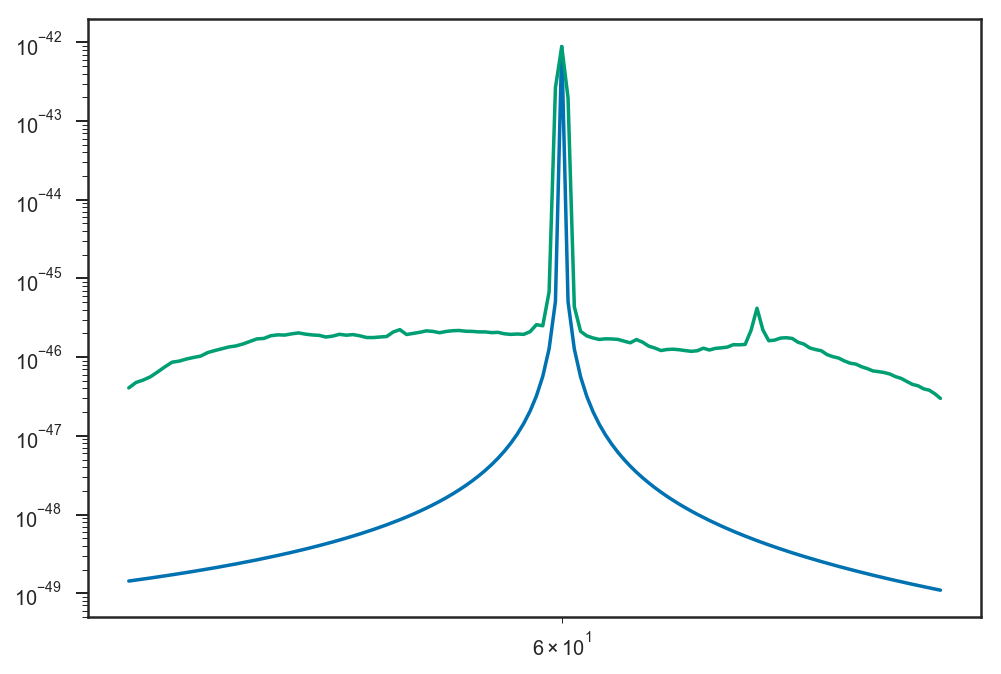

In [28]:
gp.set_parameter_vector(p0_guess)
loglog(fs8[sel], gp.kernel.get_psd(2*pi*fs8[sel])*2*pi)
loglog(fs8[sel], filtered_psd8[sel])

Alternately, you can initialise by executing the cell below, which will load a past set of samples and select `nwalkers` of them at random to start up.

In [71]:
with h5py.File('sampling.hdf5', 'r') as inp:
    chain = array(inp['chain'])
    flat_chain = chain.reshape((-1, 5))
    ps = np.random.permutation(flat_chain)[:nwalkers,:]

I used four threads because I have 4 CPUs though it is not clear that this is actually a benefit (except for the full, 4096 second run I didn't see close to 100% CPU utilisation, indicating that things are dominated by communication overhead).

In [72]:
# If sampler already exists, try to kill its Pool before resetting
try:
    sampler.pool.close()
    sampler.pool.join()
except:
    print('Couldn\'t close pool.')

nthreads = 4
sampler = emcee.EnsembleSampler(nwalkers, 5, logpost, threads=nthreads)

###### Start of Burn-In, Sampling Loop

Loop of commands for burn-in starts here and ends below at `sampler.reset`.  The process I usually follow begins by repeatedly running 128 sample MCMCs until the chain plots start to show no trend (or a less-dramatic trend, where there is at least a step-to-step scatter) and the log-posterior distribution starts to look smooth and not have a trend to it.  Between each 128 step run, I reset the sampler.  

Once the 128 step runs look good, I begin step-doubling between resets until I get a good set of chain plots, smooth-looking log-post distribution, and `acor` can compute an autocorrelation length in each dimension.  If the number of steps exceeds 512, then I thin so that there are always no more that 16384 samples in total.  I stop once I have at least 1000 effective samples.  (If you are still data tempering, i.e. you haven't included all the data in the fit yet, then you should feel free to double the data set once `acor` finds any significant number of independent samples---you don't need to have thousands and thousands, since you're just initialising the next sampler with 32 samples anyway.)

In [112]:
%time ps, lnprobs, rstate = sampler.run_mcmc(ps, 512)

CPU times: user 4 s, sys: 624 ms, total: 4.62 s
Wall time: 3min 37s


A reminder about the shape of the chain array:

In [113]:
sampler.chain.shape

(32, 512, 5)

*If* each accepted step drew an *independent* sample from the posterior, then the ACL would be 
$$
\tau = \frac{2}{p_\mathrm{acc}} - 1
$$

The ACL cannot be shorter than this at a given acceptance rate.

In [114]:
pacc = mean(sampler.acceptance_fraction)
print('ACL estimated for optimal sampling with pacc = {:.2g} is {:.2g}'.format(pacc, 2.0/pacc - 1.0))

ACL estimated for optimal sampling with pacc = 0.55 is 2.7


Here we generate a "posterior plot" and a "chain plot."  The posterior plot shows the trend of the ensemble-mean posterior with sample number; during burn-in, it will be trending up, but once the ensemble has found the peak in parameter space, it will behave randomly.  The chain plot shows the mean of the ensemble versus step number for each parameter.  We normalise each parameter to have zero mean and unit s.d.  Trends on this plot indicate that burnin is still progressing; a burned-in and converged run should have random motion in all coordinates.

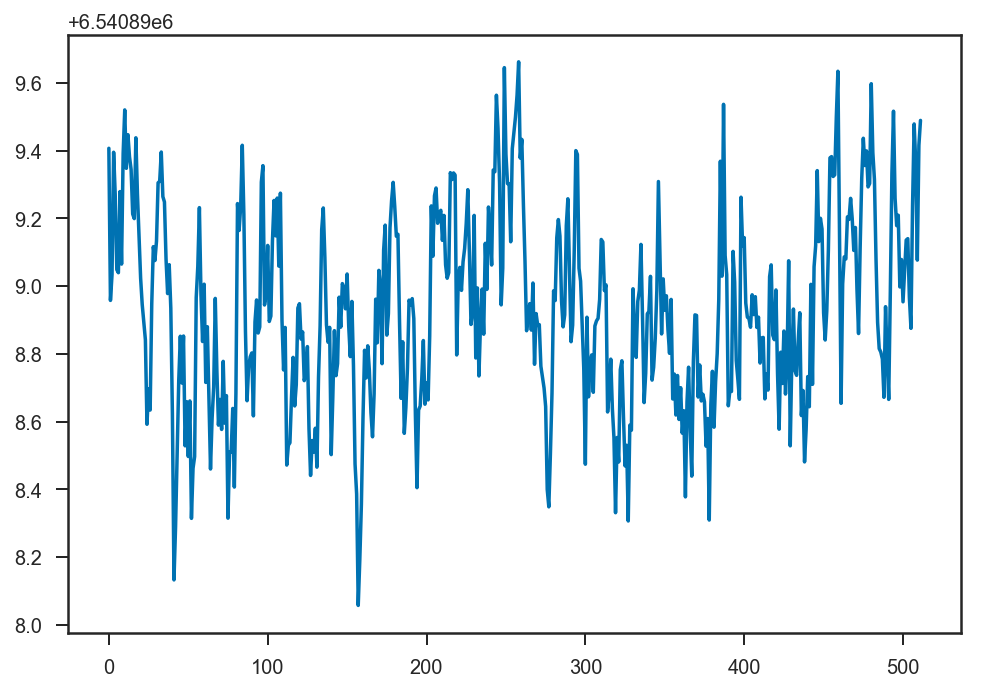

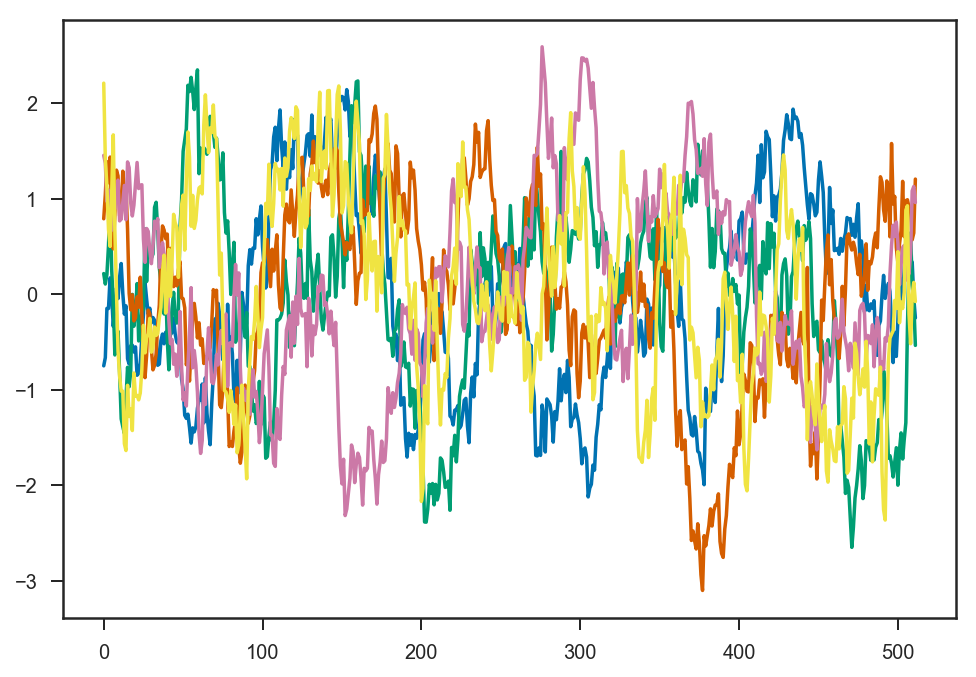

In [115]:
plot(mean(sampler.lnprobability, axis=0))

figure()
mus = mean(sampler.chain, axis=(0,1))
sigmas = std(mean(sampler.chain, axis=0), axis=0)
plot((mean(sampler.chain,axis=0)-mus)/sigmas)

And a plot of the distribution the log-probability.  When a run is burned in the typical width of the posterior distribution of the log-posterior is $\sigma_{\ln \pi} = \sqrt{N/2}$ in $N$ dimensions; and if the posterior is single-peaked and approximately Gaussian, then the distribution of log-posterior under the posterior is Gamma distributed
$$
p\left( \log \pi \right) \propto \left( \log \pi \right)^{\frac{N-1}{2}} \exp\left[ - \log \pi \right]
$$

So, if the distribution below does not look smooth, or has a width significantly above $\sqrt{N/2}$, then burnin is not done.

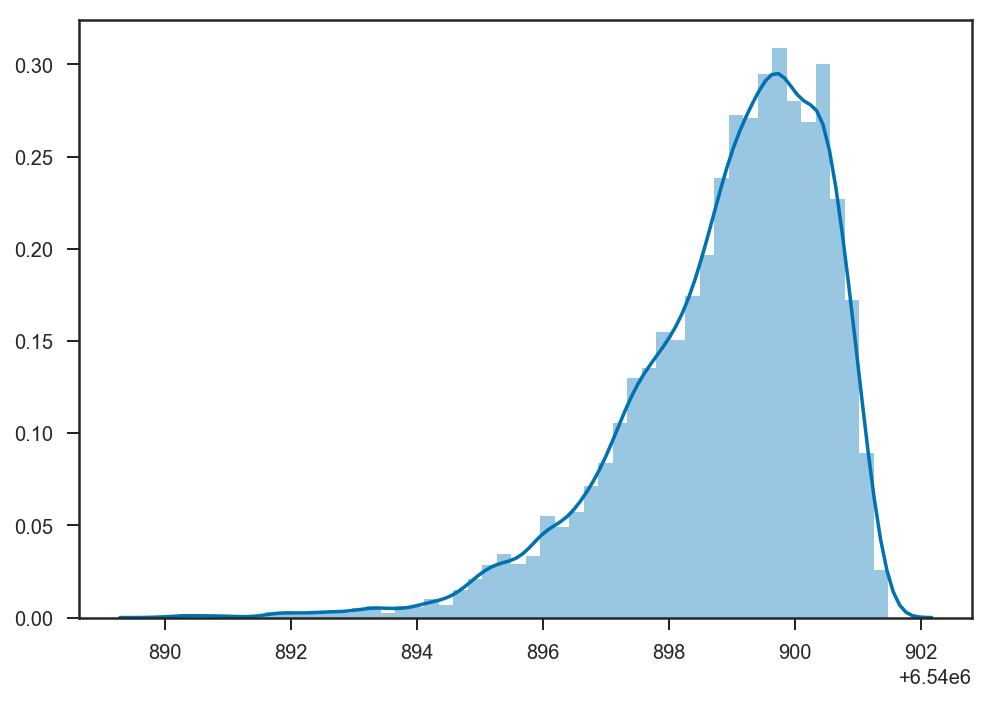

In [116]:
sns.distplot(sampler.lnprobability.flatten())

Grab a random PSD from the final state of the chain and plot it against the Welch estimate.  This is just a sanity check that the fits haven't totally gone off the rails.

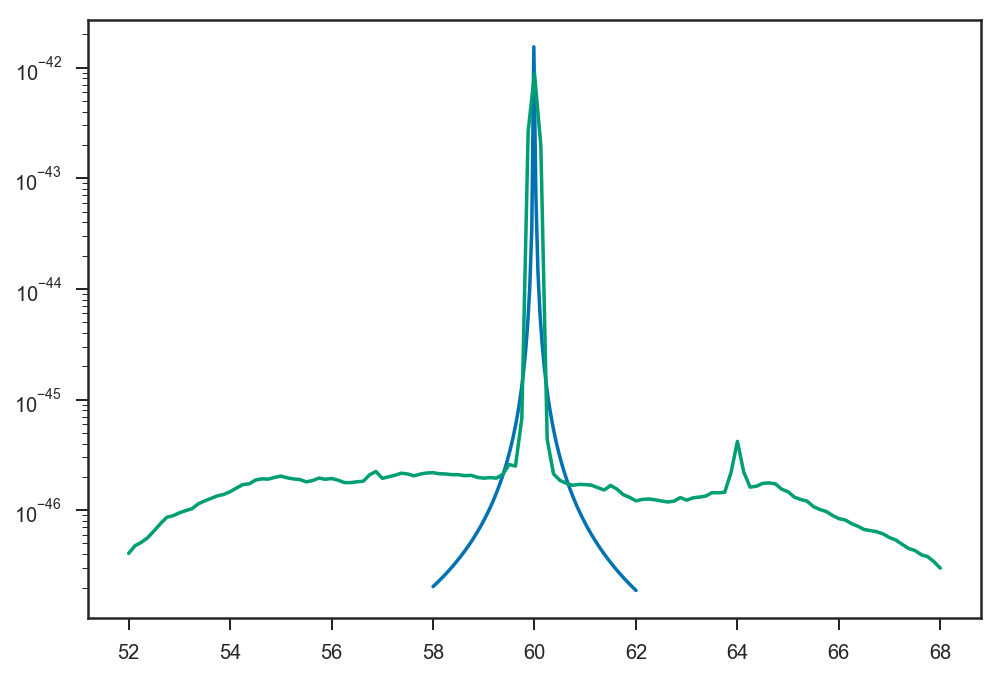

In [117]:
fs_dense = logspace(log10(58), log10(62), 100)
gp.set_parameter_vector(sampler.chain[0,-1,:])
plot(fs_dense, gp.kernel.get_psd(2*pi*fs_dense)*2*pi)
plot(fs8[sel], filtered_psd8[sel])
yscale('log')

Scatter plot and histogram of $f$ (x-axis) against $Q$ (y-axis).

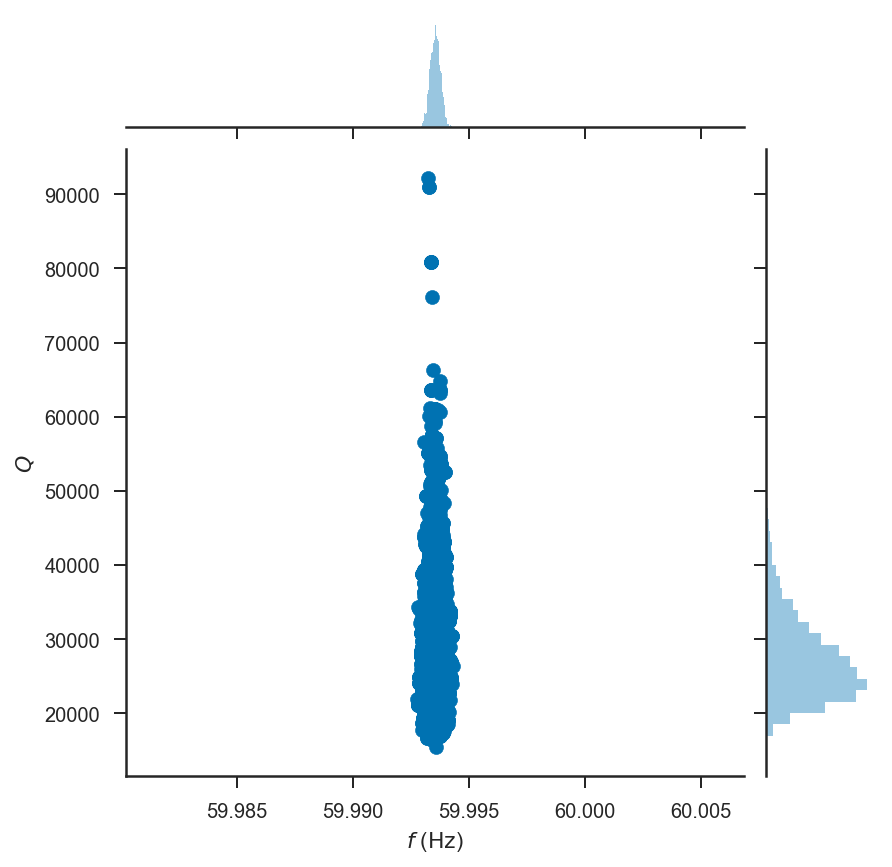

In [118]:
sns.jointplot(exp(sampler.chain[:,:,2]).flatten()/(2*pi), exp(sampler.chain[:,:,1]).flatten(), stat_func=None).set_axis_labels(r'$f$ ($\mathrm{Hz}$)', r'$Q$')

A plot of the posterior on $Q$.  The vertical line marks $Q_\mathrm{max} = fT$ where the line becomes approximately unresolved given the length of the data set (since the celerite filter tracks the phase of the line, and the line SNR is high ($\sim 100$!) it can in fact detected the wandering in phase coherency from $Q$ for $Q > Q_\mathrm{max}$, but once $Q \gg Q_\mathrm{max}$ the likelihood becomes flat because the line is just a delta-function).  If the posterior on $Q$ goes significantly above the $Q_\mathrm{max}$ line then you haven't *measured* $Q$ with your data set and you will need more data to do so.

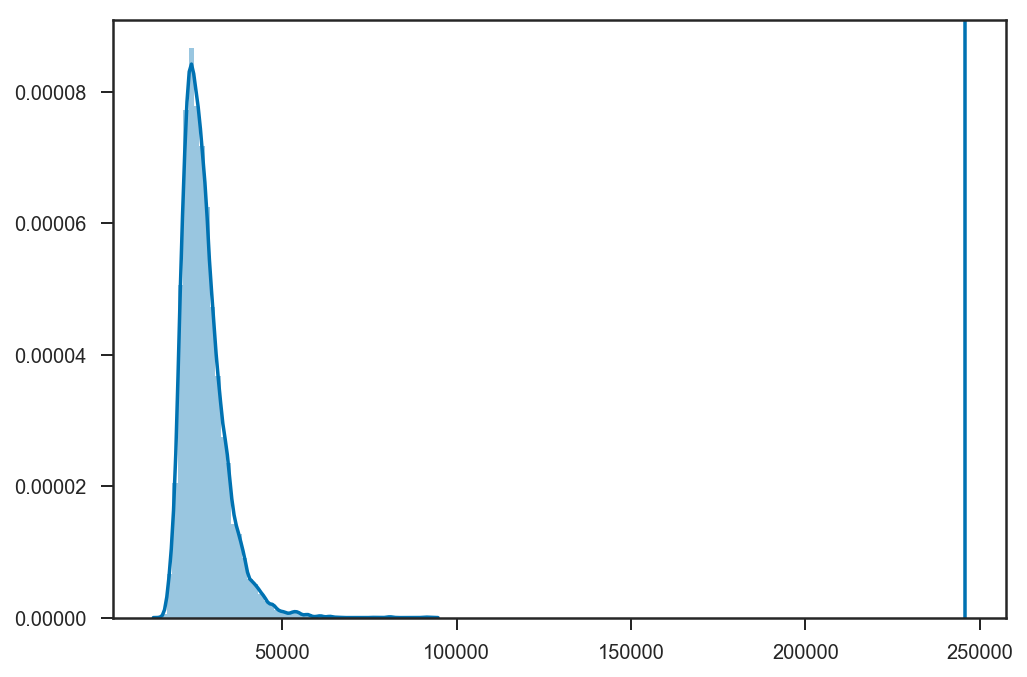

In [119]:
Qmax = 60.0*(downsampled_ts[Tend-1]-downsampled_ts[Tstart])
figure()
sns.distplot(exp(sampler.chain[:,:,1].flatten()))
axvline(Qmax)

A look at the full posterior in one- and two-dimensional slices:

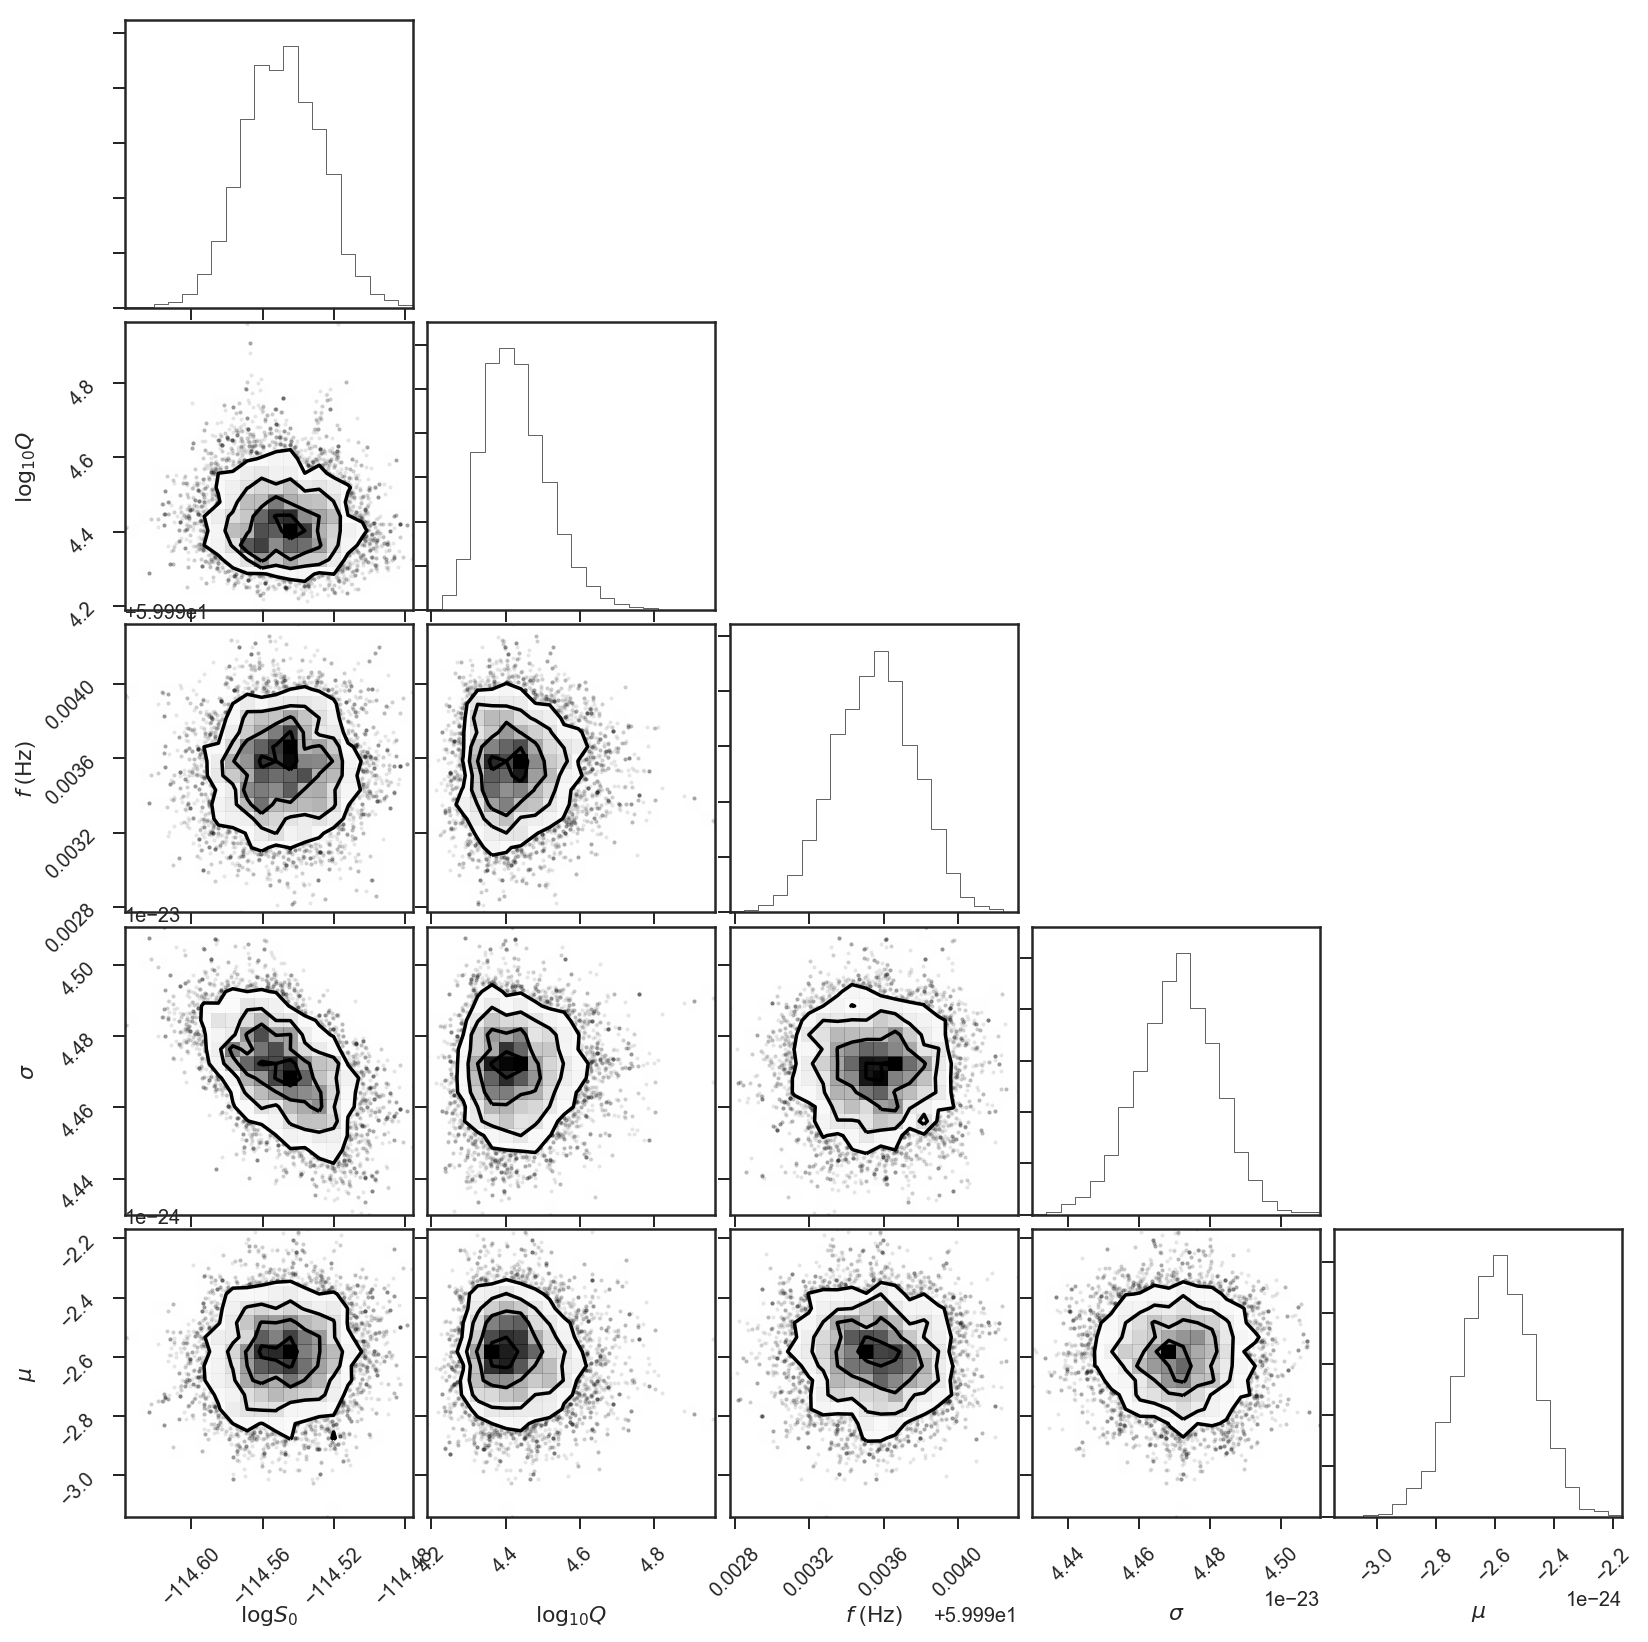

In [120]:
corner.corner(
    column_stack((
        sampler.flatchain[:,0],
        log10(exp(sampler.flatchain[:,1])),
        exp(sampler.flatchain[:,2])/(2*pi),
        exp(sampler.flatchain[:,3]),
        sampler.flatchain[:,4]*mean_scale)),
    labels=[
        r'$\log S_0$',
        r'$\log_{10} Q$',
        r'$f$ ($\mathrm{Hz}$)',
        r'$\sigma$',
        r'$\mu$']
);

Now let's try to look at the autocorrelation time:

In [121]:
acls = array([acor.acor(mean(sampler.chain[:,:,i], axis=0))[0] for i in range(sampler.chain.shape[2])])
max_acl = np.max(acls)
print('Maximum ACL is {:.2g}, for {:.0f} effective samples'.format(max_acl, sampler.chain.shape[0]*sampler.chain.shape[1]/max_acl))
print(acls)

Maximum ACL is 15, for 1082 effective samples
[  8.55018467   5.56569328  15.1399446   14.65123029   6.51231568]


Execute the cell below if the results don't look burned in.

In [111]:
sampler.reset()

If things look burned in, and you are happy with the number of effective samples, execute this cell instead to save the chains to an HDF5 file.

In [122]:
with h5py.File('sampling.hdf5', 'w') as out:
    out.attrs['Tstart'] = downsampled_ts[Tstart]
    out.attrs['Tend'] = downsampled_ts[Tend-1]
    out.create_dataset('chain', data=sampler.chain, compression='gzip', shuffle=True)
    out.create_dataset('lnprobability', data=sampler.lnprobability, compression='gzip', shuffle=True)

###### End of Burn-In and Sampling Loop

In [123]:
Qmed = exp(median(sampler.flatchain[:,1]))
print('Median Q = {:.2g}, requiring a segment length of {:.2g} to be measured acceptably'.format(Qmed, Qmed/60.0))

Median Q = 2.6e+04, requiring a segment length of 4.4e+02 to be measured acceptably


###### End of Data Tempering

## Now Compute the Residuals

Let's reload the chain:

In [124]:
with h5py.File('sampling.hdf5', 'r') as inp:
    chain = array(inp['chain'])
flatchain = chain.reshape((-1, chain.shape[2]))

In [132]:
predicted_60Hz = 0.0
Npost = 128
for p in permutation(flatchain)[:Npost,:]:
    x = p.copy()
    x[-1] = x[-1]*mean_scale # re-scale mean
    gp.set_parameter_vector(x)
    gp.compute(downsampled_ts, yerr=0) # Again, yerr is really in the Jitter term
    predicted_60Hz = predicted_60Hz + gp.predict(downsampled_strain, t=ts, return_cov=False)
predicted_60Hz = predicted_60Hz / Npost

In [133]:
h1_strain_cleaned = h1_strain - predicted_60Hz
fs8, cleaned_psd8 = ss.welch(h1_strain_cleaned, fs=4096.0, nperseg=8*4096)

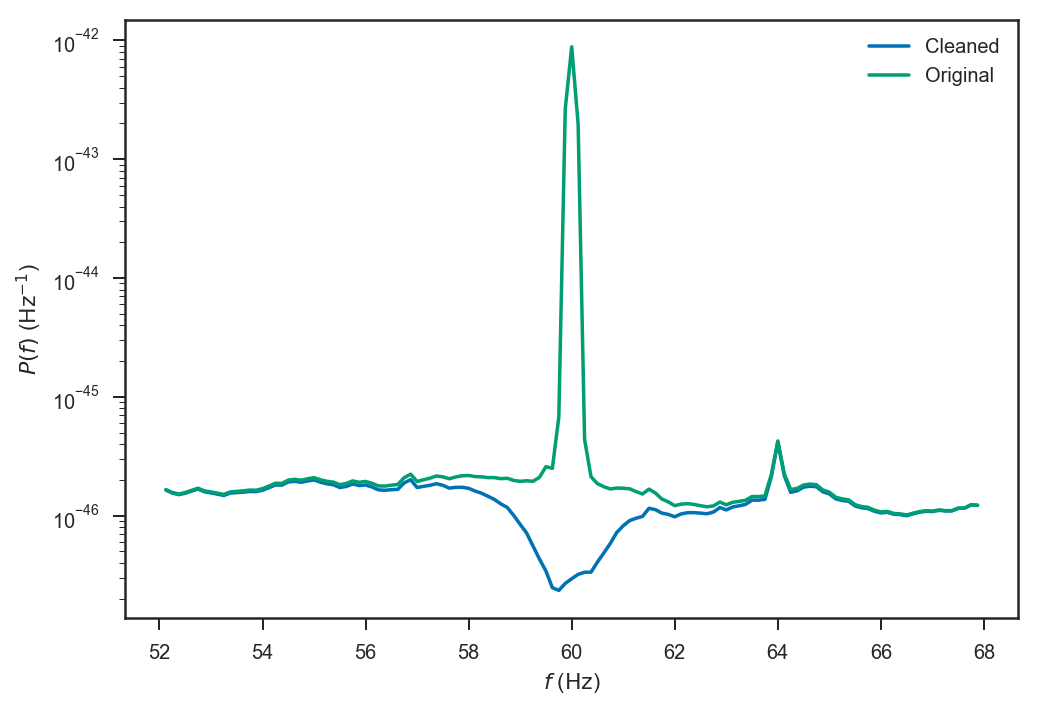

In [134]:
sel = (fs8 > flow) & (fs8 < fhigh)
plot(fs8[sel], cleaned_psd8[sel], label='Cleaned')
plot(fs8[sel], psd8[sel], label='Original')
legend(loc='best')
xlabel(r'$f$ ($\mathrm{Hz}$)')
ylabel(r'$P(f)$ ($\mathrm{Hz}^{-1}$)')
yscale('log')

In [135]:
with h5py.File('cleaned-strain.hdf5', 'w') as out:
    out.attrs['tfirst'] = ts[0]
    out.attrs['tlast'] = ts[-1]
    out.attrs['dt'] = ts[1]-ts[0]
    out.create_dataset('cleaned-strain', data=h1_strain_cleaned, shuffle=True, compression='gzip')
    out.create_dataset('60Hz-prediction', data=predicted_60Hz, shuffle=True, compression='gzip')
    out.create_dataset('strain', data=h1_strain, shuffle=True, compression='gzip')

To give a sense of scale, here is the strain data for two seconds starting 128 seconds past GW150914:

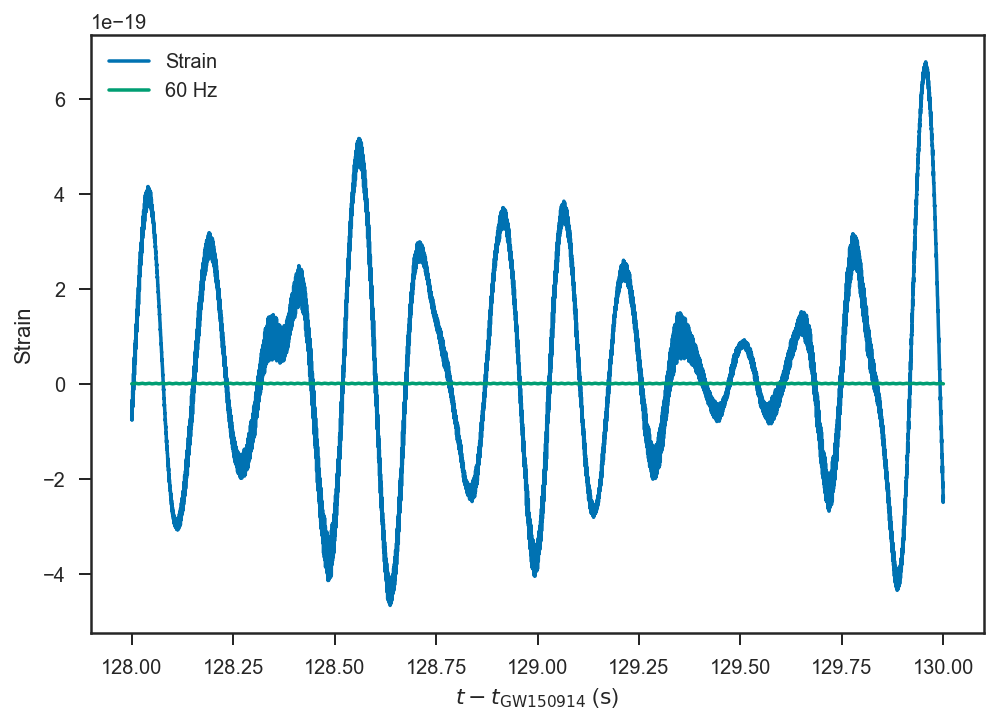

In [144]:
sel = ((ts - tGW150914) > 128) & ((ts-tGW150914) <= 130)
plot(ts[sel]-tGW150914, h1_strain[sel], label='Strain')
plot(ts[sel]-tGW150914, predicted_60Hz[sel], label='60 Hz')
legend(loc='best')
xlabel(r'$t - t_\mathrm{GW150914}$ ($\mathrm{s}$)')
ylabel(r'Strain')

And here is the 60 Hz prediction during that time.  You can see that the amplitude wanders pretty quickly while the phase is coherent for hundreds of seconds.

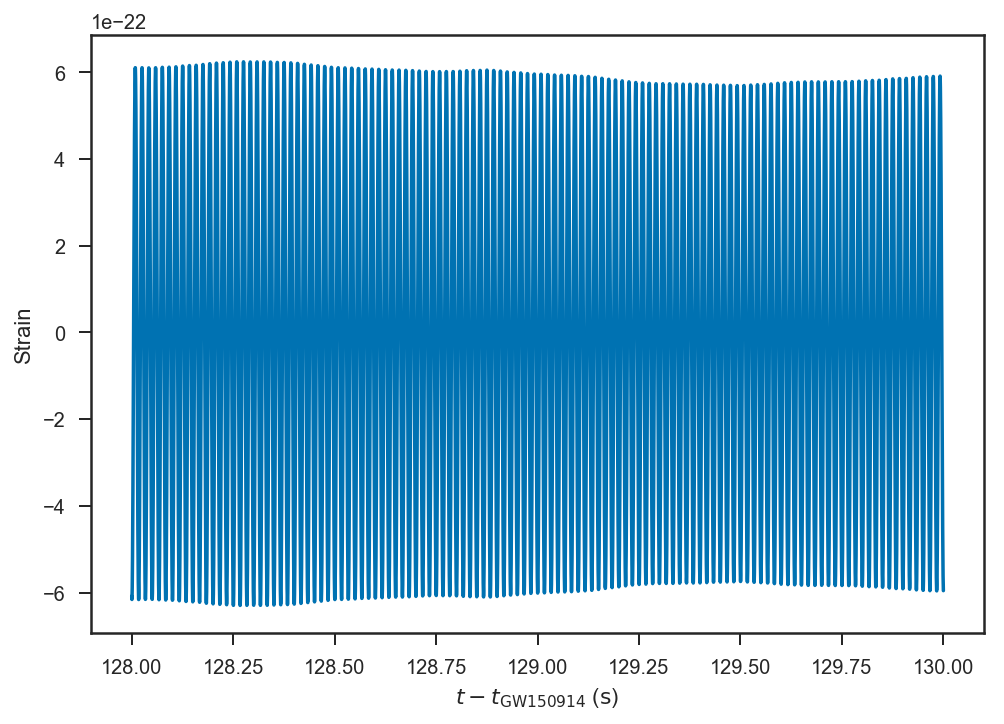

In [146]:
plot(ts[sel]-tGW150914, predicted_60Hz[sel])
xlabel(r'$t - t_\mathrm{GW150914}$ ($\mathrm{s}$)')
ylabel(r'Strain')

Let's just check that the PSDs from the first and second half of the data are consistent:

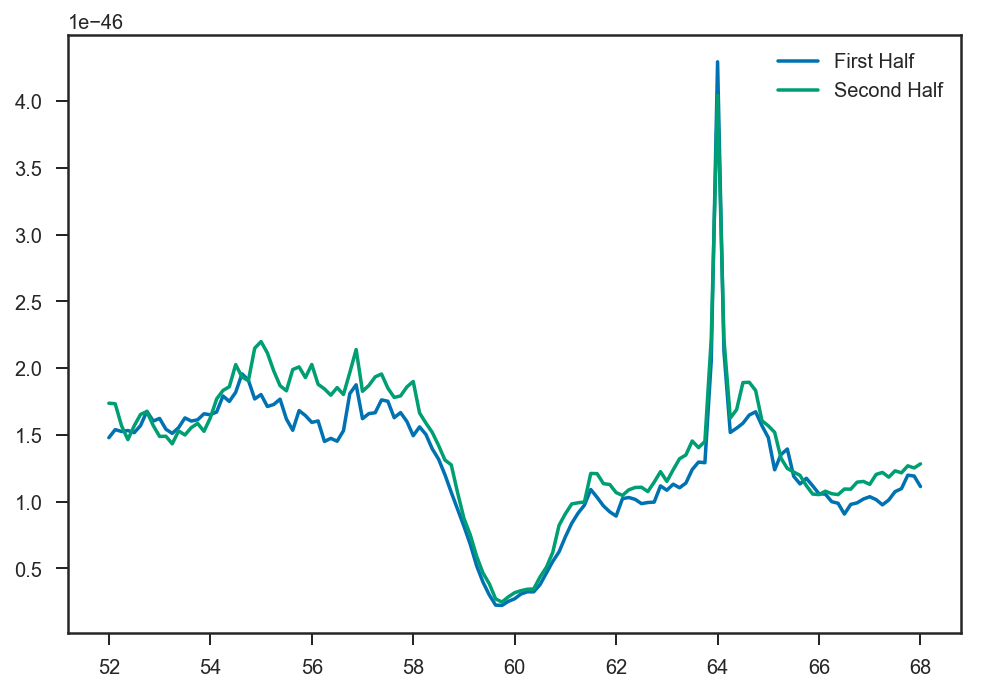

In [148]:
fs8, cleaned_half1_psd8 = ss.welch(h1_strain_cleaned[:2048*4096], fs=4096.0, nperseg=8*4096)
fs8, cleaned_half2_psd8 = ss.welch(h1_strain_cleaned[2048*4096:], fs=4096.0, nperseg=8*4096)
sel = (flow <= fs8) & (fs8 <= fhigh)
plot(fs8[sel], cleaned_half1_psd8[sel], label='First Half')
plot(fs8[sel], cleaned_half2_psd8[sel], label='Second Half')
legend(loc='best')

## Adding Extra Noise Reduces Over-Fitting?

Why is the cleaning so aggressive at removing 60 Hz power?  What happens if we add the same noise as we fit from the Jitter originally (so the total is now $\sqrt{2}$ of the original) and fit again?

In [149]:
sigma_fit = mean(exp(flatchain[:,-2]))
sigma_fit

4.4705547768884161e-23

In [150]:
extra_noise_strain = downsampled_strain + sigma_fit*randn(downsampled_strain.shape[0])

The below is just a copy of the code above, with some bits changed to use the `extra_noise_strain`:

In [153]:
def logpost_extra_noise(x):
    xx = x.copy()
    xx[-1] = x[-1]*mean_scale
    gp.set_parameter_vector(xx)
    gp.compute(downsampled_ts[Tstart:Tend], yerr=0.0) # Don't worry---yerr is degenerate with Jitter term
    
    # Now put a log-normal prior on omega0
    muo0 = log(60.0*2*pi)
    so0 = 0.01
    lp_o0 = -0.5*square((gp.get_parameter('kernel:terms[0]:log_omega0')-muo0)/so0)
    
    # Prior is p(Q) = exp(-Q/Qmax)
    Qmax = 60.0*(downsampled_ts[Tend-1]-downsampled_ts[Tstart])
    logQ = gp.get_parameter('kernel:terms[0]:log_Q')
    lp_Q = logQ - exp(logQ)/Qmax
    
    return gp.log_likelihood(extra_noise_strain[Tstart:Tend]) + lp_o0 + lp_Q

In [154]:
ps = permutation(flatchain)[:nwalkers,:]

In [156]:
try:
    extra_noise_sampler.pool.close()
    extra_noise_sampler.pool.join()
except:
    print('couldn\'t close pool')

extra_noise_sampler = emcee.EnsembleSampler(nwalkers, 5, logpost_extra_noise, threads=4)

In [170]:
%time ps, lnprobs, rstate = extra_noise_sampler.run_mcmc(ps, 256)

CPU times: user 2.08 s, sys: 340 ms, total: 2.42 s
Wall time: 1min 48s


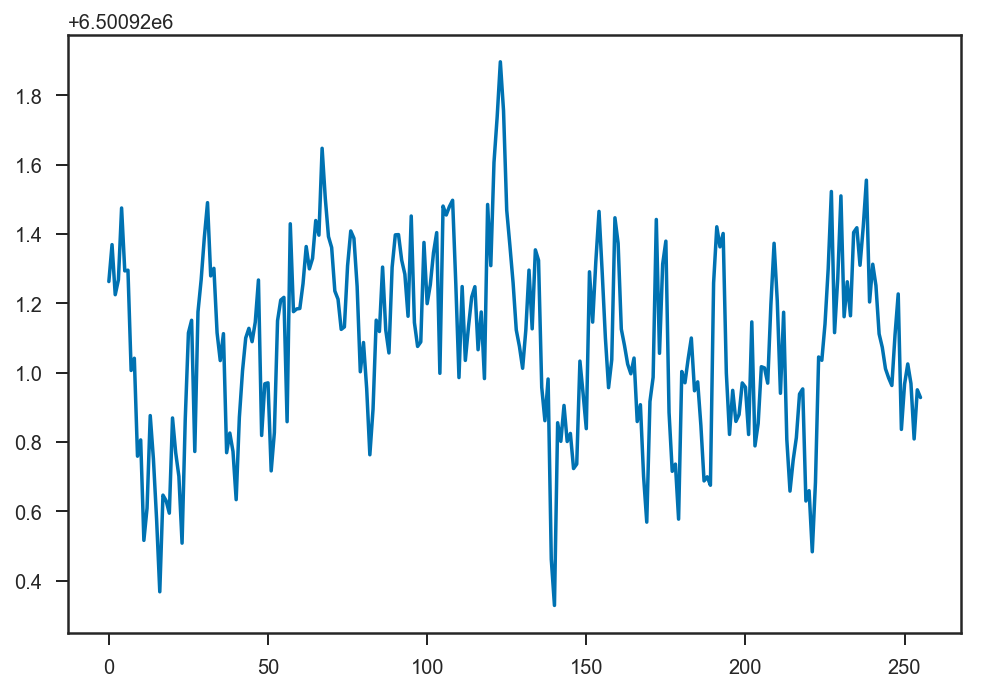

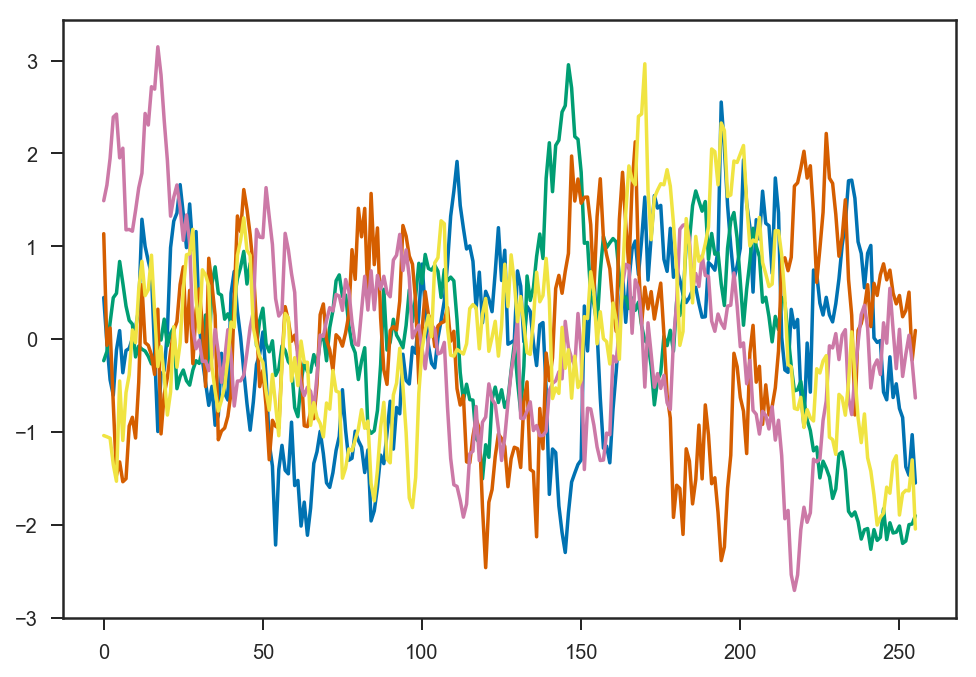

In [171]:
plot(mean(extra_noise_sampler.lnprobability, axis=0))

figure()
mus = mean(extra_noise_sampler.chain, axis=(0,1))
sigmas = std(mean(extra_noise_sampler.chain, axis=0), axis=0)
plot((mean(extra_noise_sampler.chain,axis=0)-mus)/sigmas)

In [172]:
acls = array([acor.acor(mean(extra_noise_sampler.chain[:,:,k], axis=0))[0] for k in range(extra_noise_sampler.chain.shape[2])])
max_acl = np.max(acls)
print('{:.0f} effective samples'.format(extra_noise_sampler.flatchain.shape[0]/max_acl))

1508 effective samples


You can see that the amplitude of the Jitter term increases by $\sim \sqrt{2}$ from $\sim 4$ to $\sim 6 \times 10^{-23}$.

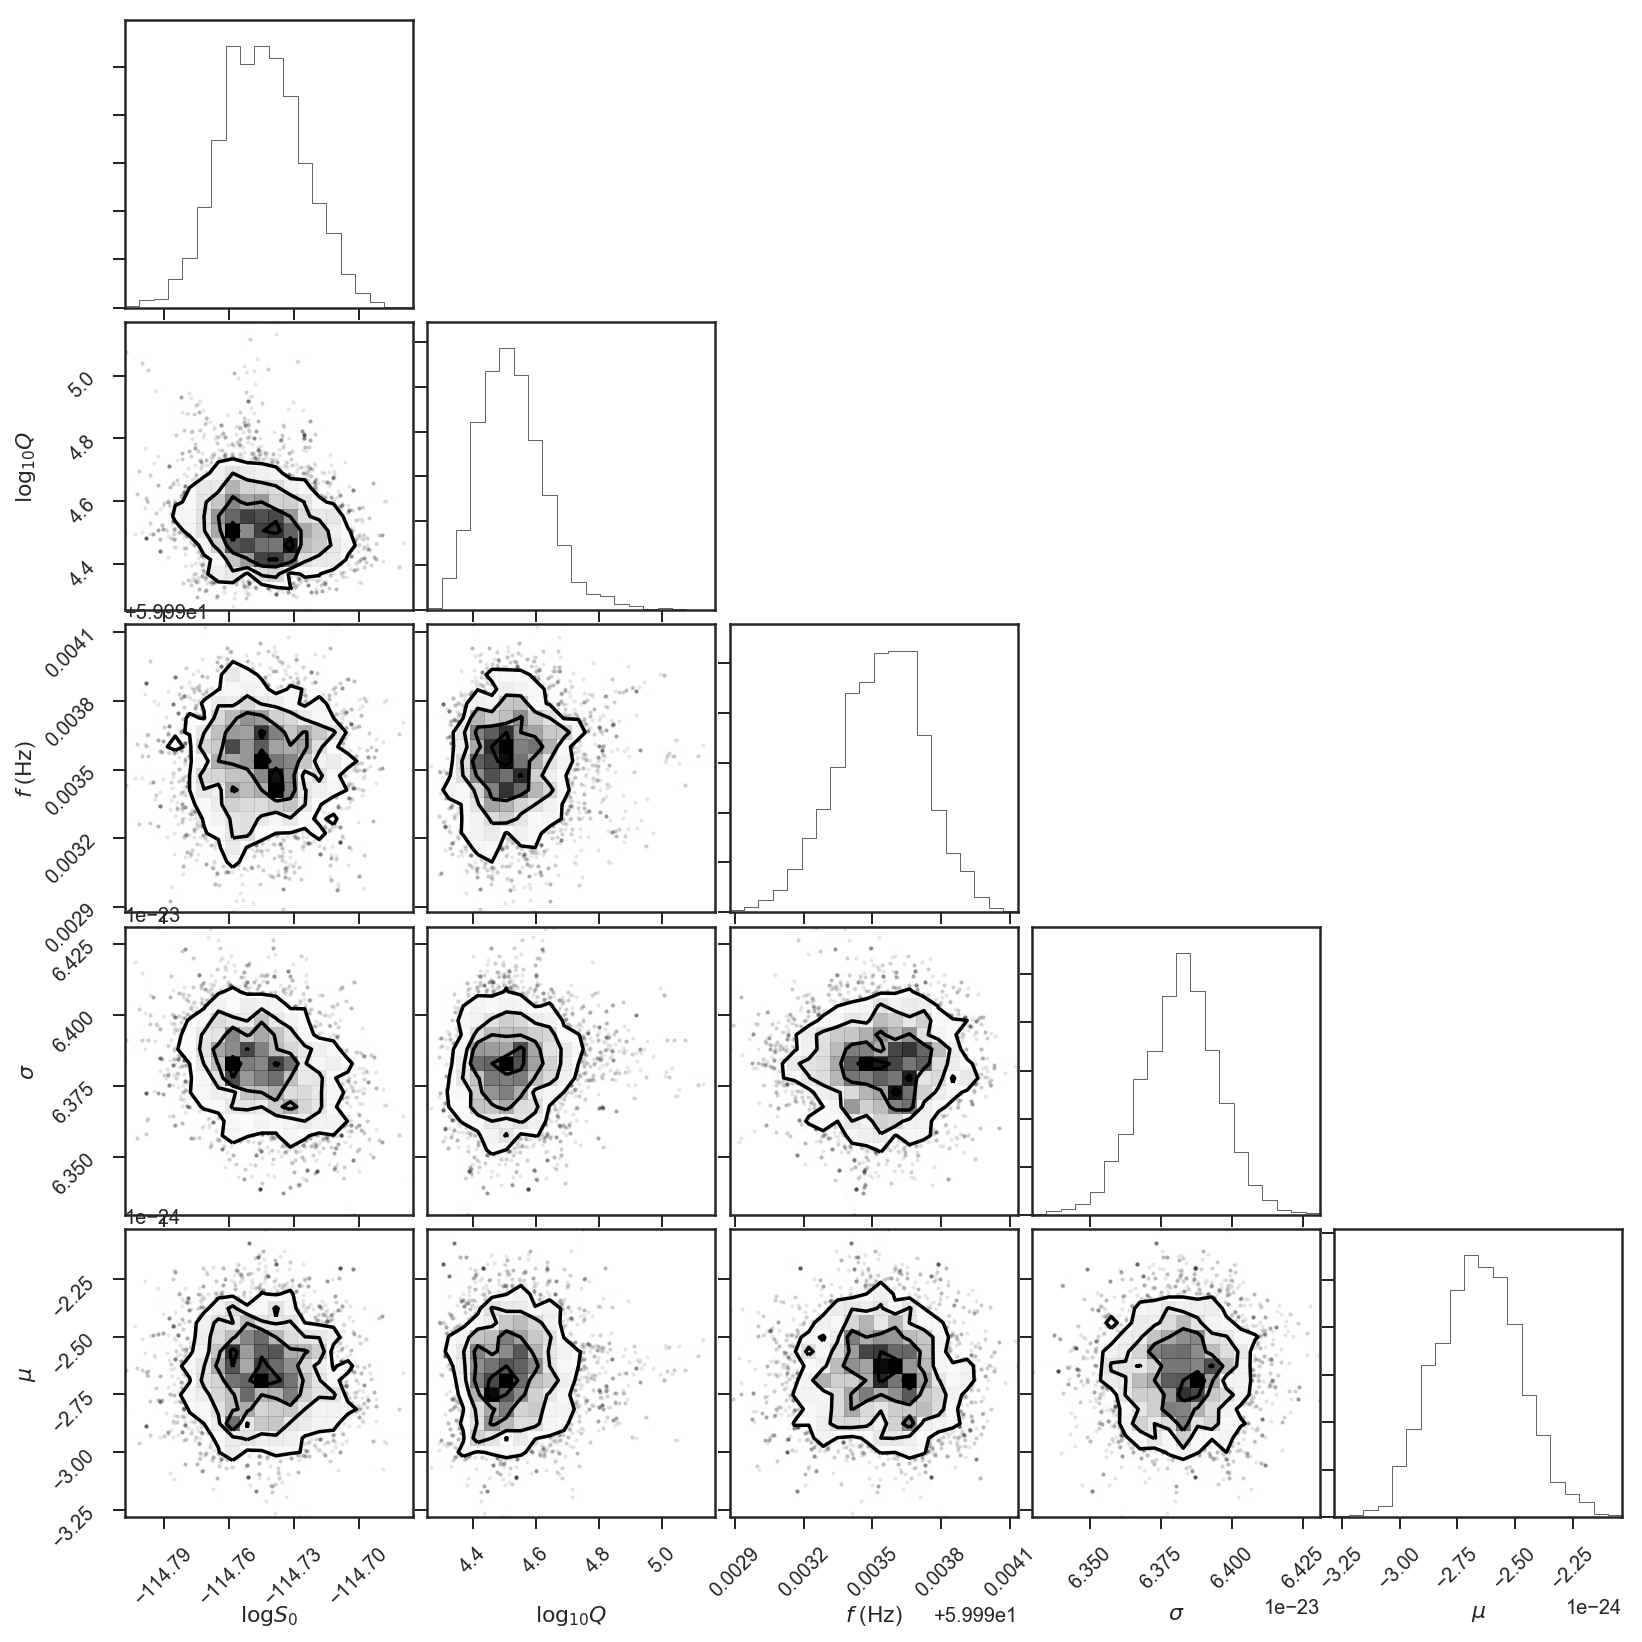

In [173]:
corner.corner(
    column_stack((
        extra_noise_sampler.flatchain[:,0],
        log10(exp(extra_noise_sampler.flatchain[:,1])),
        exp(extra_noise_sampler.flatchain[:,2])/(2*pi),
        exp(extra_noise_sampler.flatchain[:,3]),
        extra_noise_sampler.flatchain[:,4]*mean_scale)),
    labels=[
        r'$\log S_0$',
        r'$\log_{10} Q$',
        r'$f$ ($\mathrm{Hz}$)',
        r'$\sigma$',
        r'$\mu$']
);

Only run the cell below if you want to go back and increase the number of samples during burnin:

In [169]:
extra_noise_sampler.reset()

Now we predict the state of the line at all times based on the noisy observations:

In [174]:
predicted_60Hz_en = 0.0
Npost = 128
for p in permutation(extra_noise_sampler.flatchain)[:Npost,:]:
    x = p.copy()
    x[-1] = x[-1]*mean_scale # re-scale mean
    gp.set_parameter_vector(x)
    gp.compute(downsampled_ts, yerr=0) # Again, yerr is really in the Jitter term
    predicted_60Hz_en = predicted_60Hz_en + gp.predict(extra_noise_strain, t=ts, return_cov=False)
predicted_60Hz_en = predicted_60Hz_en / Npost

In [175]:
h1_strain_cleaned_en = h1_strain - predicted_60Hz_en
fs8, cleaned_psd8_en = ss.welch(h1_strain_cleaned_en, fs=4096.0, nperseg=8*4096)

And subtracting, computing the PSD gives the following, which shows that the subtraction is probably a bit "weak" now, since there is a hint of the peak, but we seem to have done less to neighbouring frequencies.

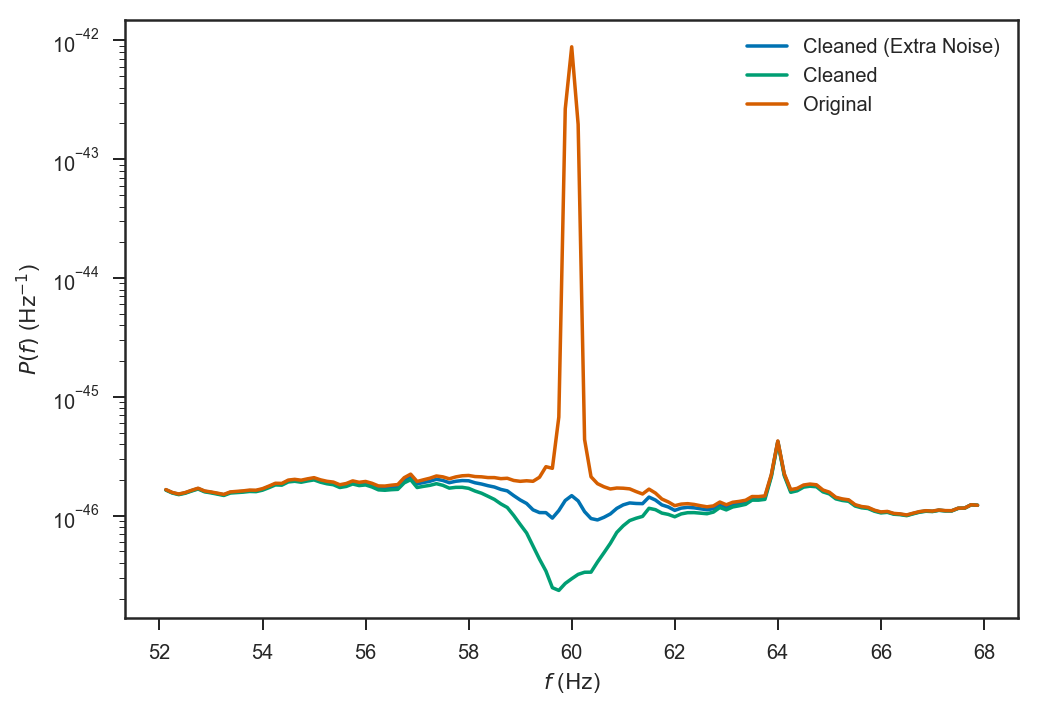

In [176]:
sel = (fs8 > flow) & (fs8 < fhigh)
plot(fs8[sel], cleaned_psd8_en[sel], label='Cleaned (Extra Noise)')
plot(fs8[sel], cleaned_psd8[sel], label='Cleaned')
plot(fs8[sel], psd8[sel], label='Original')
legend(loc='best')
xlabel(r'$f$ ($\mathrm{Hz}$)')
ylabel(r'$P(f)$ ($\mathrm{Hz}^{-1}$)')
yscale('log')

Let's compare $Q$ from the two runs---maybe that will explain why we haven't changed the wings of the line in the noisy fit.  Interestingly, we find a higher Q from the noisy fit; maybe washing out the effect of the nearby line near $64\,\mathrm{Hz}$ is helpful?  This is probably worth further investigation if we were to use this as an actual data cleaning method.

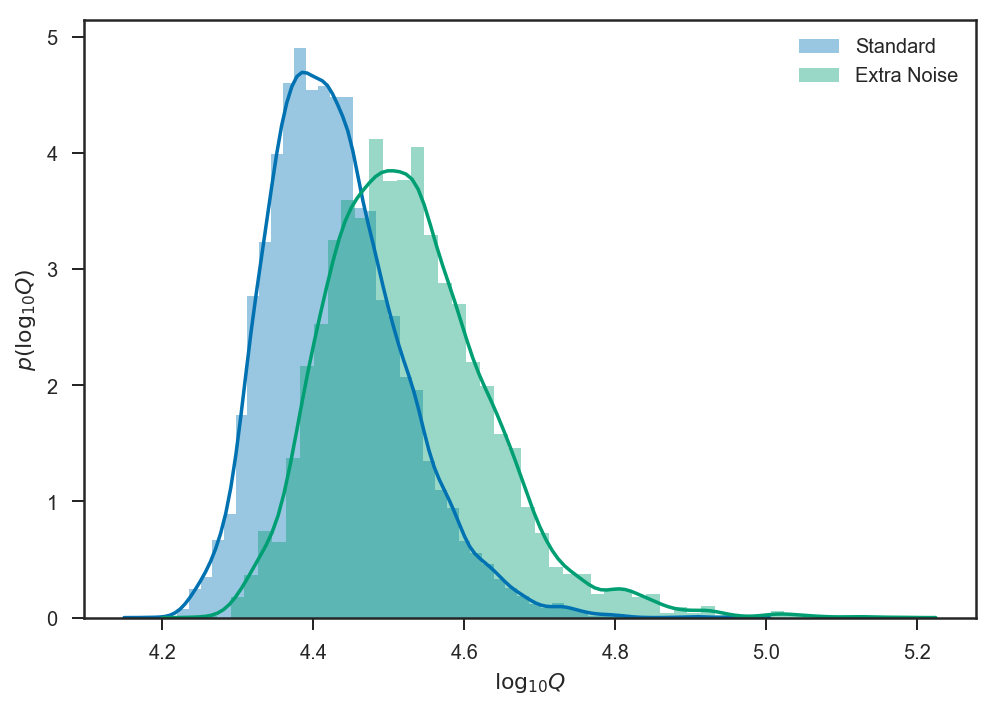

In [178]:
sns.distplot(flatchain[:, 1]/log(10), label='Standard')
sns.distplot(extra_noise_sampler.flatchain[:,1]/log(10), label='Extra Noise')
xlabel(r'$\log_{10} Q$')
ylabel(r'$p\left( \log_{10} Q \right)$')
legend(loc='best')

In [10]:
from tqdm import tqdm

In [11]:
for s,e in tqdm(zip(arange(0, len(h1_strain), 4096), arange(4096, len(h1_strain)+1, 4096))):
    h1_strain[s:e] = h1_strain[s:e] - predicted_60Hz[s:e]

NameError: name 'arange' is not defined